## 使用python 和 numpy 从0到1构建一个神经网络框架 MiniTensorFlow


> Node（网络节点结构）：
   + forward: *Function*, how to calculate the inputs
   + backward:*Function*, how to get the gradients when backpropagation
   + gradients: *Mapper*, the gradient map this node of its inputs node
   + inputs: *List*, the input nodes of the node
   + outputs: *List*, the output node of this node

In [1]:
import numpy as np

In [67]:
class Node:
    """
    Each node in the neural network will have these attributes and methods
    """
    def __init__(self, inputs=[]):
        # inputs和outputs都是Node
        self.inputs = inputs
        self.outputs = []
        
        # inputs的节点的输出节点为当前节点
        for n in self.inputs:
            n.outputs.append(self)
        
        # 节点的输出值 如 wx+b的值
        self.value = None
        
        # 相对于所有输出节点的梯度
        self.gradients = {
            # if is wx + b, this will put the
            # w: x
            # x: w
            # b: 1
        }
        
    
    def forward(self):
        """
        Forward propagation 
        compute the output value based on the input nodes and store the value
        into self.value
        """
        raise NotImplemented
    
    def backward(self):
        """
        Back Propagation
        compute the gradient of each input node and store the value
        into self.gradients
        """
        raise NotImplemented

In [98]:
class Input(Node):
    def __init__(self, name=''):
        """
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        """
        Node.__init__(self, inputs=[])
        self.name = name
    
    def forward(self, value=None):
        """
        Only Input node is the node where the value may be passed as argument to forward().
        All other node implementations should get the value of the previous node from self.inbound_nodes.
        (只有Input类型的节点调用forward时需要传值，其他类型的节点需要从前任节点中获取输入值)
        Example：
            val0： self.inbound_nodes[0].value
            节点的输出值就是输入参数
        """
        if value is not None:
            print('>>>> here')
            self.value = value
    
    def backward(self):
        self.gradients = {self: 0}
        
        for n in self.outputs:
            # 输出节点的梯度 * 当前节点的梯度
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
    
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [4]:
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)
    
    def calculate(self):
        """
        输出值是所有输入节点的value和
        """
        self.value = sum(map(lambda n: n.value, self.inputs)) 

In [106]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])
        
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        self.value = np.dot(inputs, weights) + bias
    
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

In [6]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)
    
    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = grad_cost * self.partial

In [7]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        Node.__init__(self, [y_true, y_hat])
    
    def forward(self):
        y_true = self.inputs[0].value.reshape(-1, 1)
        y_hat = self.inputs[1].value.reshape(-1, 1)
        assert(y_true.shape == y_hat.shape)
        
        self.diff = y_true - y_hat
        self.value = np.mean(self.diff ** 2)
    
    
    def backward(self):
        self.m = self.inputs[0].value.shape[0]
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = -1 * (2 / self.m) * self.diff

In [95]:
def forward_and_backward(toplogical_sorted_graph):
    for n in toplogical_sorted_graph:
        n.forward()
    
    for n in toplogical_sorted_graph[::-1]:
        n.backward()

In [9]:
def toplogical_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    (网络节点拓扑排序)
    
    feed_dict: A dictionary where the key is a 'Input' node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n, Input):
            n.value = feed_dict[n]
            
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            
            # 入度为 0的节点
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [20]:
def sgd_update(trainable_nodes, learning_rate=1e-3):
    for node in trainable_nodes:
        node.value += -1 * learning_rate * node.gradients[node]

## TEST

In [73]:
from sklearn.datasets import load_boston
from sklearn.utils import resample, shuffle

In [74]:
data = load_boston()
X_ = data['data']
y_ = data['target']

In [75]:
X_.shape, y_.shape

((506, 13), (506,))

In [77]:
# Normalize
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [89]:
# Build nodes
X, y = Input(name='X'), Input(name='y')
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')

In [105]:
# Build Neural Network
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

3
3


In [91]:
# 初始化参数
n_features = X_.shape[1]
n_hidden = 10
W1_, b1_= np.random.randn(n_features, n_hidden), np.zeros(n_hidden)
W2_, b2_ = np.random.randn(n_hidden, 1), np.zeros(1)

In [92]:
feed_dict = {
    # Node : value
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

In [93]:
graph = toplogical_sort(feed_dict)

In [94]:
# 经过拓扑排序后的节点列表
graph

[Input Node: b2,
 Input Node: X,
 Input Node: W2,
 Input Node: W1,
 Input Node: b1,
 Input Node: y,

In [100]:
epochs = 100
m = X_.shape[0]
batch_size = 64
steps_per_epoch = m // batch_size
trainables = [W1, b1, W2, b2]
losses = []
print('Total number of examples = {}, steps_per_epoch = {}'.format(m, steps_per_epoch))

Total number of examples = 506, steps_per_epoch = 7


In [101]:
for i in range(epochs):
    loss = 0
    
    for j in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        X.value = X_batch
        y.value = y_batch
        
        forward_and_backward(graph)
        
        rate = 1e-3
        sgd_update(trainables, rate)
        loss += graph[-1].value
    
    if i % 100 == 0:
        print('Epoch:{}, Loss:{:.3f}'.format(i, loss / steps_per_epoch))
        losses.append(loss)

Epoch:0, Loss:523.829


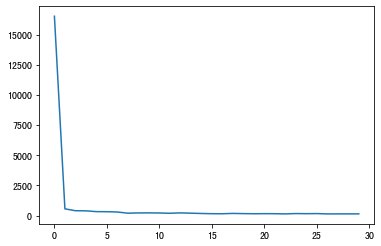

In [65]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)